#  Four Bin Instructional
 This example is a generalization of the on/off problem.

 This example is a generalization of the on/off problem.
It's a common setup for SUSY searches.  Imagine that one has two
variables "x" and "y" (eg. missing ET and SumET), see figure.
The signal region has high values of both of these variables (top right).
One can see low values of "x" or "y" acting as side-bands.  If we
just used "y" as a sideband, we would have the on/off problem.
 - In the signal region we observe non events and expect s+b events.
 - In the region with low values of "y" (bottom right)
   we observe noff events and expect tau*b events.
Note the significance of tau.  In the background only case:

```cpp
   tau ~ <expectation off> / <expectation on>
```

If tau is known, this model is sufficient, but often tau is not known exactly.
So one can use low values of "x" as an additional constraint for tau.
Note that this technique critically depends on the notion that the
joint distribution for "x" and "y" can be factorized.
Generally, these regions have many events, so it the ratio can be
measured very precisely there.  So we extend the model to describe the
left two boxes... denoted with "bar".
  - In the upper left we observe nonbar events and expect bbar events
  - In the bottom left we observe noffbar events and expect tau bbar events
Note again we have:

```cpp
   tau ~ <expectation off bar> / <expectation on bar>
```

One can further expand the model to account for the systematic associated
to assuming the distribution of "x" and "y" factorizes (eg. that
tau is the same for off/on and offbar/onbar). This can be done in several
ways, but here we introduce an additional parameter rho, which so that
one set of models will use tau and the other tau*rho. The choice is arbitrary,
but it has consequences on the numerical stability of the algorithms.
The "bar" measurements typically have more events (& smaller relative errors).
If we choose

```cpp
<expectation noffbar> = tau * rho * <expectation noonbar>
```

the product tau*rho will be known very precisely (~1/sqrt(bbar)) and the contour
in those parameters will be narrow and have a non-trivial tau~1/rho shape.
However, if we choose to put rho on the non/noff measurements (where the
product will have an error `~1/sqrt(b))`, the contours will be more amenable
to numerical techniques.  Thus, here we choose to define:

```cpp
   tau := <expectation off bar> / (<expectation on bar>)
   rho := <expectation off> / (<expectation on> * tau)

^ y
|
|---------------------------+
|               |           |
|     nonbar    |    non    |
|      bbar     |    s+b    |
|               |           |
|---------------+-----------|
|               |           |
|    noffbar    |    noff   |
|    tau bbar   | tau b rho |
|               |           |
+-----------------------------> x
```

Left in this way, the problem is under-constrained.  However, one may
have some auxiliary measurement (usually based on Monte Carlo) to
constrain rho.  Let us call this auxiliary measurement that gives
the nominal value of rho "rhonom".  Thus, there is a 'constraint' term in
the full model: P(rhonom | rho).  In this case, we consider a Gaussian
constraint with standard deviation sigma.

In the example, the initial values of the parameters are:

```cpp
  - s    = 40
  - b    = 100
  - tau  = 5
  - bbar = 1000
  - rho  = 1
  (sigma for rho = 20%)
```

and in the toy dataset:

```cpp
   - non = 139
   - noff = 528
   - nonbar = 993
   - noffbar = 4906
   - rhonom = 1.27824
```

Note, the covariance matrix of the parameters has large off-diagonal terms.
Clearly s,b are anti-correlated.  Similarly, since noffbar >> nonbar, one would
expect bbar,tau to be anti-correlated.

This can be seen below.

```cpp
            GLOBAL      b    bbar   rho      s     tau
        b  0.96820   1.000  0.191 -0.942 -0.762 -0.209
     bbar  0.91191   0.191  1.000  0.000 -0.146 -0.912
      rho  0.96348  -0.942  0.000  1.000  0.718 -0.000
        s  0.76250  -0.762 -0.146  0.718  1.000  0.160
      tau  0.92084  -0.209 -0.912 -0.000  0.160  1.000
```

Similarly, since tau*rho appears as a product, we expect rho,tau
to be anti-correlated. When the error on rho is significantly
larger than 1/sqrt(bbar), tau is essentially known and the
correlation is minimal (tau mainly cares about bbar, and rho about b,s).
In the alternate parametrization (bbar* tau * rho) the correlation coefficient
for rho,tau is large (and negative).

The code below uses best-practices for RooFit & RooStats as of June 2010.

It proceeds as follows:
 - create a workspace to hold the model
 - use workspace factory to quickly create the terms of the model
 - use workspace factory to define total model (a prod pdf)
 - create a RooStats ModelConfig to specify observables, parameters of interest
 - add to the ModelConfig a prior on the parameters for Bayesian techniques
   note, the pdf it is factorized for parameters of interest & nuisance params
 - visualize the model
 - write the workspace to a file
 - use several of RooStats IntervalCalculators & compare results




**Author:**   authors: Kyle Cranmer, Tanja Rommerskirchen  
<i><small>This notebook tutorial was automatically generated with <a href= "https://github.com/root-project/root/blob/master/documentation/doxygen/converttonotebook.py">ROOTBOOK-izer</a> from the macro found in the ROOT repository  on Thursday, August 29, 2019 at 03:07 AM.</small></i>

In [1]:
%%cpp -d
#include "TStopwatch.h"
#include "TCanvas.h"
#include "TROOT.h"
#include "RooPlot.h"
#include "RooAbsPdf.h"
#include "RooWorkspace.h"
#include "RooDataSet.h"
#include "RooGlobalFunc.h"
#include "RooFitResult.h"
#include "RooRandom.h"
#include "RooStats/ProfileLikelihoodCalculator.h"
#include "RooStats/LikelihoodInterval.h"
#include "RooStats/LikelihoodIntervalPlot.h"
#include "RooStats/BayesianCalculator.h"
#include "RooStats/MCMCCalculator.h"
#include "RooStats/MCMCInterval.h"
#include "RooStats/MCMCIntervalPlot.h"
#include "RooStats/ProposalHelper.h"
#include "RooStats/SimpleInterval.h"
#include "RooStats/FeldmanCousins.h"
#include "RooStats/PointSetInterval.h"

In [2]:
%%cpp -d
// This is a workaround to make sure the namespace is used inside functions
using namespace RooFit;
using namespace RooStats;

 Arguments are defined. 

In [3]:
bool doBayesian = false;
bool doFeldmanCousins = false;
bool doMCMC = false;

Let's time this challenging example

In [4]:
TStopwatch t;
t.Start();

Set roofit random seed for reproducible results

In [5]:
RooRandom::randomGenerator()->SetSeed(4357);


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



Make model

In [6]:
RooWorkspace *wspace = new RooWorkspace("wspace");
wspace->factory("Poisson::on(non[0,1000], sum::splusb(s[40,0,100],b[100,0,300]))");
wspace->factory("Poisson::off(noff[0,5000], prod::taub(b,tau[5,3,7],rho[1,0,2]))");
wspace->factory("Poisson::onbar(nonbar[0,10000], bbar[1000,500,2000])");
wspace->factory("Poisson::offbar(noffbar[0,1000000], prod::lambdaoffbar(bbar, tau))");
wspace->factory("Gaussian::mcCons(rhonom[1.,0,2], rho, sigma[.2])");
wspace->factory("PROD::model(on,off,onbar,offbar,mcCons)");
wspace->defineSet("obs", "non,noff,nonbar,noffbar,rhonom");

wspace->factory("Uniform::prior_poi({s})");
wspace->factory("Uniform::prior_nuis({b,bbar,tau, rho})");
wspace->factory("PROD::prior(prior_poi,prior_nuis)");

----------------------------------
 Control some interesting variations
 define parameers of interest
 for 1-d plots

In [7]:
wspace->defineSet("poi", "s");
wspace->defineSet("nuis", "b,tau,rho,bbar");

For 2-d plots to inspect correlations:
  wspace->defineSet("poi","s,rho");

Test simpler cases where parameters are known.
  wspace->var("tau")->setConstant();
  wspace->var("rho")->setConstant();
  wspace->var("b")->setConstant();
  wspace->var("bbar")->setConstant();

Inspect workspace
  wspace->Print();

----------------------------------------------------------
 Generate toy data
 generate toy data assuming current value of the parameters
 import into workspace.
 add Verbose() to see how it's being generated

In [8]:
RooDataSet *data = wspace->pdf("model")->generate(*wspace->set("obs"), 1);

Data->print("v");

In [9]:
wspace->import(*data);

[#1] INFO:ObjectHandling -- RooWorkspace::import(wspace) importing dataset modelData


----------------------------------
 Now the statistical tests
 model config

In [10]:
ModelConfig *modelConfig = new ModelConfig("FourBins");
modelConfig->SetWorkspace(*wspace);
modelConfig->SetPdf(*wspace->pdf("model"));
modelConfig->SetPriorPdf(*wspace->pdf("prior"));
modelConfig->SetParametersOfInterest(*wspace->set("poi"));
modelConfig->SetNuisanceParameters(*wspace->set("nuis"));
wspace->import(*modelConfig);
wspace->writeToFile("FourBin.root");

-------------------------------------------------
 If you want to see the covariance matrix uncomment
  wspace->pdf("model")->fitTo(*data);

Use profilelikelihood

In [11]:
ProfileLikelihoodCalculator plc(*data, *modelConfig);
plc.SetConfidenceLevel(0.95);
LikelihoodInterval *plInt = plc.GetInterval();
RooFit::MsgLevel msglevel = RooMsgService::instance().globalKillBelow();
RooMsgService::instance().setGlobalKillBelow(RooFit::FATAL);
plInt->LowerLimit(*wspace->var("s")); // get ugly print out of the way. Fix.
RooMsgService::instance().setGlobalKillBelow(msglevel);

[#1] INFO:Minization -- createNLL: caching constraint set under name CONSTR_OF_PDF_model_FOR_OBS_noff:noffbar:non:nonbar:rhonom with 0 entries
[#0] PROGRESS:Minization -- ProfileLikelihoodCalcultor::DoGLobalFit - find MLE 
[#0] PROGRESS:Minization -- ProfileLikelihoodCalcultor::DoMinimizeNLL - using Minuit / Migrad with strategy 1
[#1] INFO:Minization -- RooMinimizer::optimizeConst: activating const optimization
[#1] INFO:Minization --  The following expressions will be evaluated in cache-and-track mode: (on,off,onbar,offbar,mcCons)
[#1] INFO:Minization -- 
  RooFitResult: minimized FCN value: 16.2872, estimated distance to minimum: 1.21263e-07
                covariance matrix quality: Full, accurate covariance matrix
                Status : MINIMIZE=0 

    Floating Parameter    FinalValue +/-  Error   
  --------------------  --------------------------
                     b    8.3602e+01 +/-  1.39e+01
                  bbar    9.9301e+02 +/-  3.15e+01
                   rho    1.2

Use feldmacousins (takes ~20 min)

In [12]:
FeldmanCousins fc(*data, *modelConfig);
fc.SetConfidenceLevel(0.95);

Number counting: dataset always has 1 entry with n events observed

In [13]:
fc.FluctuateNumDataEntries(false);
fc.UseAdaptiveSampling(true);
fc.SetNBins(40);
PointSetInterval *fcInt = NULL;
if (doFeldmanCousins) {                          // takes 7 minutes
   fcInt = (PointSetInterval *)fc.GetInterval(); // fix cast
}

Use bayesiancalculator (only 1-d parameter of interest, slow for this problem)

In [14]:
BayesianCalculator bc(*data, *modelConfig);
bc.SetConfidenceLevel(0.95);
SimpleInterval *bInt = NULL;
if (doBayesian && wspace->set("poi")->getSize() == 1) {
   bInt = bc.GetInterval();
} else {
   cout << "Bayesian Calc. only supports on parameter of interest" << endl;
}

Bayesian Calc. only supports on parameter of interest


Use mcmccalculator  (takes about 1 min)
 Want an efficient proposal function, so derive it from covariance
 matrix of fit

In [15]:
RooFitResult *fit = wspace->pdf("model")->fitTo(*data, Save());
ProposalHelper ph;
ph.SetVariables((RooArgSet &)fit->floatParsFinal());
ph.SetCovMatrix(fit->covarianceMatrix());
ph.SetUpdateProposalParameters(kTRUE); // auto-create mean vars and add mappings
ph.SetCacheSize(100);
ProposalFunction *pf = ph.GetProposalFunction();

MCMCCalculator mc(*data, *modelConfig);
mc.SetConfidenceLevel(0.95);
mc.SetProposalFunction(*pf);
mc.SetNumBurnInSteps(500); // first N steps to be ignored as burn-in
mc.SetNumIters(50000);
mc.SetLeftSideTailFraction(0.5); // make a central interval
MCMCInterval *mcInt = NULL;
if (doMCMC)
   mcInt = mc.GetInterval();

[#1] INFO:Minization -- createNLL picked up cached consraints from workspace with 0 entries
[#1] INFO:Minization -- RooMinimizer::optimizeConst: activating const optimization
[#1] INFO:Minization --  The following expressions will be evaluated in cache-and-track mode: (on,off,onbar,offbar,mcCons)
 **********
 **    1 **SET PRINT           1
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 b            1.17958e+02  1.38657e+01    0.00000e+00  3.00000e+02
     2 bbar         1.00111e+03  3.15028e+01    5.00000e+02  2.00000e+03
     3 rho          9.28979e-01  1.98664e-01    0.00000e+00  2.00000e+00
     4 s            1.20959e+01  1.78108e+01    0.00000e+00  1.00000e+02
 MINUIT WARNING IN PARAMETR
 ============== VARIABLE4 BROUGHT BACK INSIDE LIMITS.
     5 tau          4.89226e+00  1.71714e-01    3.00000e+00  7.00000e+00
 **********
 **    3 **SET ERR         0.5
 **********
 **********
 **  

----------------------------------
 Make some  plots

In [16]:
TCanvas *c1 = (TCanvas *)gROOT->Get("c1");
if (!c1)
   c1 = new TCanvas("c1");

if (doBayesian && doMCMC) {
   c1->Divide(3);
   c1->cd(1);
} else if (doBayesian || doMCMC) {
   c1->Divide(2);
   c1->cd(1);
}

LikelihoodIntervalPlot *lrplot = new LikelihoodIntervalPlot(plInt);
lrplot->Draw();

if (doBayesian && wspace->set("poi")->getSize() == 1) {
   c1->cd(2);
   // the plot takes a long time and print lots of error
   // using a scan it is better
   bc.SetScanOfPosterior(20);
   RooPlot *bplot = bc.GetPosteriorPlot();
   bplot->Draw();
}

if (doMCMC) {
   if (doBayesian && wspace->set("poi")->getSize() == 1)
      c1->cd(3);
   else
      c1->cd(2);
   MCMCIntervalPlot mcPlot(*mcInt);
   mcPlot.Draw();
}

[#1] INFO:Minization -- RooProfileLL::evaluate(nll_model_modelData_Profile[s]) Creating instance of MINUIT
[#1] INFO:Minization -- RooProfileLL::evaluate(nll_model_modelData_Profile[s]) determining minimum likelihood for current configurations w.r.t all observable
[#1] INFO:Minization -- RooProfileLL::evaluate(nll_model_modelData_Profile[s]) minimum found at (s=55.4077)
.
[#1] INFO:Minization -- RooProfileLL::evaluate(nll_model_modelData_Profile[s]) Creating instance of MINUIT
[#1] INFO:Minization -- RooProfileLL::evaluate(nll_model_modelData_Profile[s]) determining minimum likelihood for current configurations w.r.t all observable
[#0] ERROR:InputArguments -- RooArgSet::checkForDup: ERROR argument with name s is already in this set
[#1] INFO:Minization -- RooProfileLL::evaluate(nll_model_modelData_Profile[s]) minimum found at (s=55.4105)
.....................................................................................................................................................

----------------------------------
 querry intervals

In [17]:
cout << "Profile Likelihood interval on s = [" << plInt->LowerLimit(*wspace->var("s")) << ", "
     << plInt->UpperLimit(*wspace->var("s")) << "]" << endl;

Profile Likelihood interval on s = [12.1902, 88.6871]


Profile likelihood interval on s = [12.1902, 88.6871]

In [18]:
if (doBayesian && wspace->set("poi")->getSize() == 1) {
   cout << "Bayesian interval on s = [" << bInt->LowerLimit() << ", " << bInt->UpperLimit() << "]" << endl;
}

if (doFeldmanCousins) {
   cout << "Feldman Cousins interval on s = [" << fcInt->LowerLimit(*wspace->var("s")) << ", "
        << fcInt->UpperLimit(*wspace->var("s")) << "]" << endl;
   // Feldman Cousins interval on s = [18.75 +/- 2.45, 83.75 +/- 2.45]
}

if (doMCMC) {
   cout << "MCMC interval on s = [" << mcInt->LowerLimit(*wspace->var("s")) << ", "
        << mcInt->UpperLimit(*wspace->var("s")) << "]" << endl;
   // MCMC interval on s = [15.7628, 84.7266]
}

t.Print();

Real time 0:00:02, CP time 0.670


Draw all canvases 

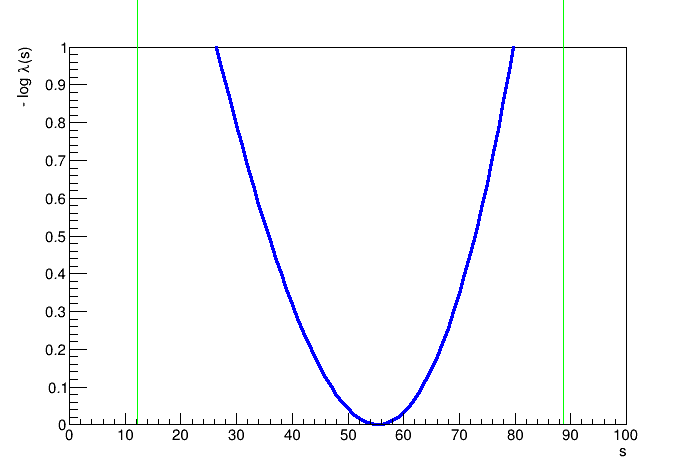

In [19]:
gROOT->GetListOfCanvases()->Draw()